In [2]:
import math

import equinox as eqx
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import optax  # https://github.com/deepmind/optax
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
def dataloader(arrays, batch_size):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size
            
            
            
def get_data(dataset_size,func, key,std_error=0.0):
    x = jnp.expand_dims(jnp.linspace(0, 8 * math.pi, dataset_size),axis=1)
    func_value = func(x)
    
    
    
    func_value_with_noise = func_value + jrandom.normal(key, (dataset_size,1))*std_error
    
    input_data = jnp.concatenate([x,func_value_with_noise],axis=1)
    
    output_data = func_value_with_noise < func_value

    return input_data, output_data


In [6]:
cubic = lambda x: x**3

In [12]:
xs,ys = get_data(100,jnp.sin,jax.random.key(0),std_error=0.1)

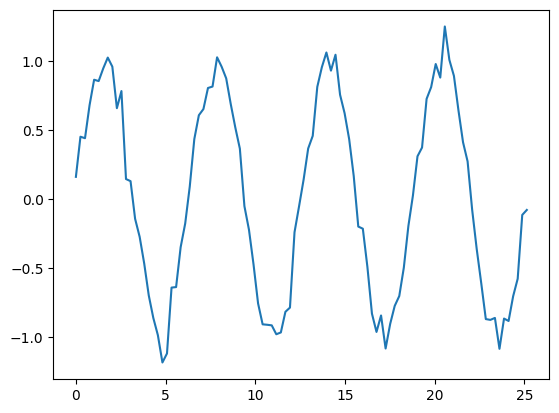

In [13]:
plt.plot(xs[:,0],xs[:,1])

In [14]:
# jax.config.update("jax_debug_nans", True)
from jaxtyping import Float, Array
class MLP(eqx.Module):
    layers: list

    def __init__(self, in_size, out_size, width_size, depth, key):
        keys = jax.random.split(key, depth + 1)
        self.layers = []
        # hidden layers
        for i in range(depth):
            self.layers.append(
                eqx.nn.Linear(
                    in_size if i == 0 else width_size,
                    width_size,
                    key=keys[i]
                )
            )
        # output layer
        self.layers.append(eqx.nn.Linear(width_size, out_size, key=keys[-1]))

    def __call__(self, x):
        # assert not jnp.any(jnp.isnan(x)), "x contains NaN values"
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return jax.nn.sigmoid(self.layers[-1](x))

In [ ]:
def main(
    dataset_size=10000,
    batch_size=32,
    learning_rate=3e-3,
    steps=200,
    width_size=64,
    depth=3,
    seed=5678,
):
    data_key, model_key = jrandom.split(jrandom.PRNGKey(seed), 2)
    
    lin_x = lambda x: x
    xs, ys = get_data(dataset_size,jnp.sin, key=data_key,std_error=0.1)
    iter_data = dataloader((xs, ys), batch_size)

    model = MLP(in_size=2, out_size=1, width_size=width_size, depth=depth, key=model_key)
    



    @eqx.filter_value_and_grad
    def compute_loss(model, x, y,epsilon=1e-8):
            
        pred_y = jax.vmap(model)(x)
        
        pred_y = jnp.clip(pred_y, epsilon, 1 - epsilon)
        
        return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))

    # Important for efficiency whenever you use JAX: wrap everything into a single JIT
    # region.
    @eqx.filter_jit
    def make_step(model, x, y, opt_state):
        loss, grads = compute_loss(model, x, y)
        # updates, opt_state = optim.update(grads, opt_state)
        updates, opt_state = optim.update(grads, opt_state,params=model)
        
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    optim = optax.adamw(learning_rate)
    opt_state = optim.init(model)
    losses = []
    for step, (x, y) in zip(range(steps), iter_data):
        loss, model, opt_state = make_step(model, x, y, opt_state)
        print(loss)
        if jnp.isnan(loss):
            print("Warning: loss is NaN at step", step)
            break
        loss = loss.item()
        print(f"step={step}, loss={loss}")
        losses.append(loss)

    pred_ys = jax.vmap(model)(xs)
    num_correct = jnp.sum((pred_ys > 0.5) == ys)
    final_accuracy = (num_correct / dataset_size).item()
    print(f"final_accuracy={final_accuracy}")
    return model, xs, ys, pred_ys, losses

In [12]:
model,xs,ys,pred_ys,losses = main(dataset_size=1000,learning_rate=1e-4,steps=10000,width_size=128,depth=5,batch_size=32)

ValueError: You are using a transformation that requires the current value of parameters, but you are not passing `params` when calling `update`.

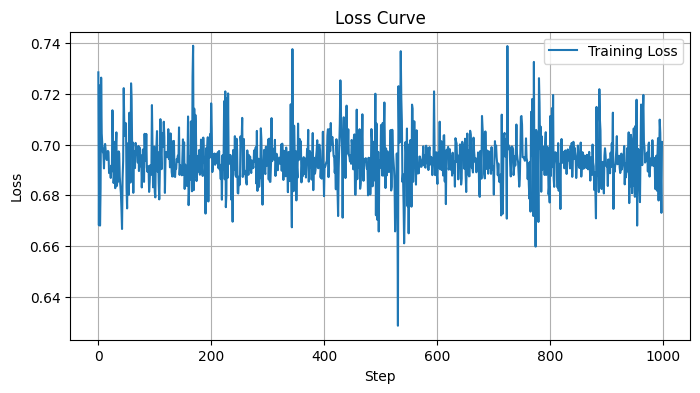

In [177]:
import matplotlib 
import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import optax



import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()
